In [1]:
library(tidyverse)
library(ggrepel)
library(ggsci)
library(cowplot)
library(openxlsx)
theme_set(theme_cowplot())

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
TBall_info <- read_csv('all_info.csv')

Rows: 419 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): strain, fullname, query, ancestor, mut
dbl (4): adv_BA2, adv_BA2_75, adv_BA5, adv_ancestor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
mut_diff <- function(query_s, ref_s){
    Vquery <- query_s %>% str_split(',') %>% unlist %>% unname
    Vref <- ref_s %>% str_split(',') %>% unlist %>% unname
    
    add <- setdiff(Vquery, Vref)
    rev <- setdiff(Vref, Vquery) 

    all <- bind_rows(
        tibble(mut=add, type='add'),
        tibble(mut=rev, type='rev')
    ) %>% mutate(site=str_extract(mut, '\\d+') %>% as.double) %>% arrange(site) %>%
        # deal with mutations to another a.a. For example, F486S in ref_s, while F486P in query_s
        group_by(site) %>% distinct(site, .keep_all=TRUE) %>%
        # reverse mutation
        mutate(raw = str_split(mut, '\\d+') %>% map_chr(~.x[1]),
               to = str_split(mut, '\\d+') %>% map_chr(~.x[2])) %>%
        mutate(mut=ifelse(type=='rev', str_extract(mut, '\\d+') %>% {str_glue('{to}{.}{raw}')}, mut)) %>%
        pull(mut)
    dif_s <- str_c(all, collapse=',')
    return (dif_s)

}

In [4]:
Vmut_fullname <- TBall_info %>% pull(mut, fullname)
Vmut_fullname_near_ancestor <- c()
for (i in 1:length(Vmut_fullname)) {
    # for each full name string as s
    s <- names(Vmut_fullname[i])
    
    Ncut <- str_count(s, '\\.')
    near_ancestor <- s
    # for each ancestor name cut by dot, find if it is in Vmut_fullname
    for (j in rev(1:Ncut)) {
        s_cut <- str_split(s, '\\.') %>% map_chr(~str_c(.x[1:j], collapse='.'))
        if (s_cut %in% names(Vmut_fullname)) {
            near_ancestor <- s_cut
            break
        }
    }
    
    # fetch different mutation against nearest ancestor
    mut_new <- mut_diff(Vmut_fullname[s], Vmut_fullname[near_ancestor])
    Vmut_fullname_near_ancestor[s] <- mut_new
}

In [5]:
TBall_info <- TBall_info %>% mutate(mut_near_ancestor=Vmut_fullname_near_ancestor)

In [6]:
########
## Plot
########

In [7]:
# keep the strains that had growth advantages over their corresponding clade ancestors
# keep the mutations from independent evolution
TBtemp <- TBall_info %>% filter(adv_ancestor > 0) %>% select(strain, mut=mut_near_ancestor)

In [8]:
Vtemp <- TBtemp %>% pull(mut, strain)

In [9]:
TBmut_temp <- tibble()
for (i in 1:length(Vtemp)){
  v <- Vtemp[i]
  tb <- tibble(mut=str_split(v, ',') %>% unlist, strain=names(v)) %>% mutate(site=str_extract(mut, '\\d+') %>% as.double)
  TBmut_temp <- bind_rows(TBmut_temp, tb)
}

In [10]:
# RBD mutations
TBmut_temp <- TBmut_temp %>% filter(site>319, site<541)

In [11]:
TBmut_plot <- TBmut_temp %>% select(-mut) %>% group_by(site) %>% summarise(n_strain=n())

In [12]:
# zero mutation sites
Vmut_nozero <- TBmut_plot %>% pull(site)
TBmut_plot <- bind_rows(TBmut_plot, tibble(site=setdiff(319:541, Vmut_nozero), n_strain=0))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


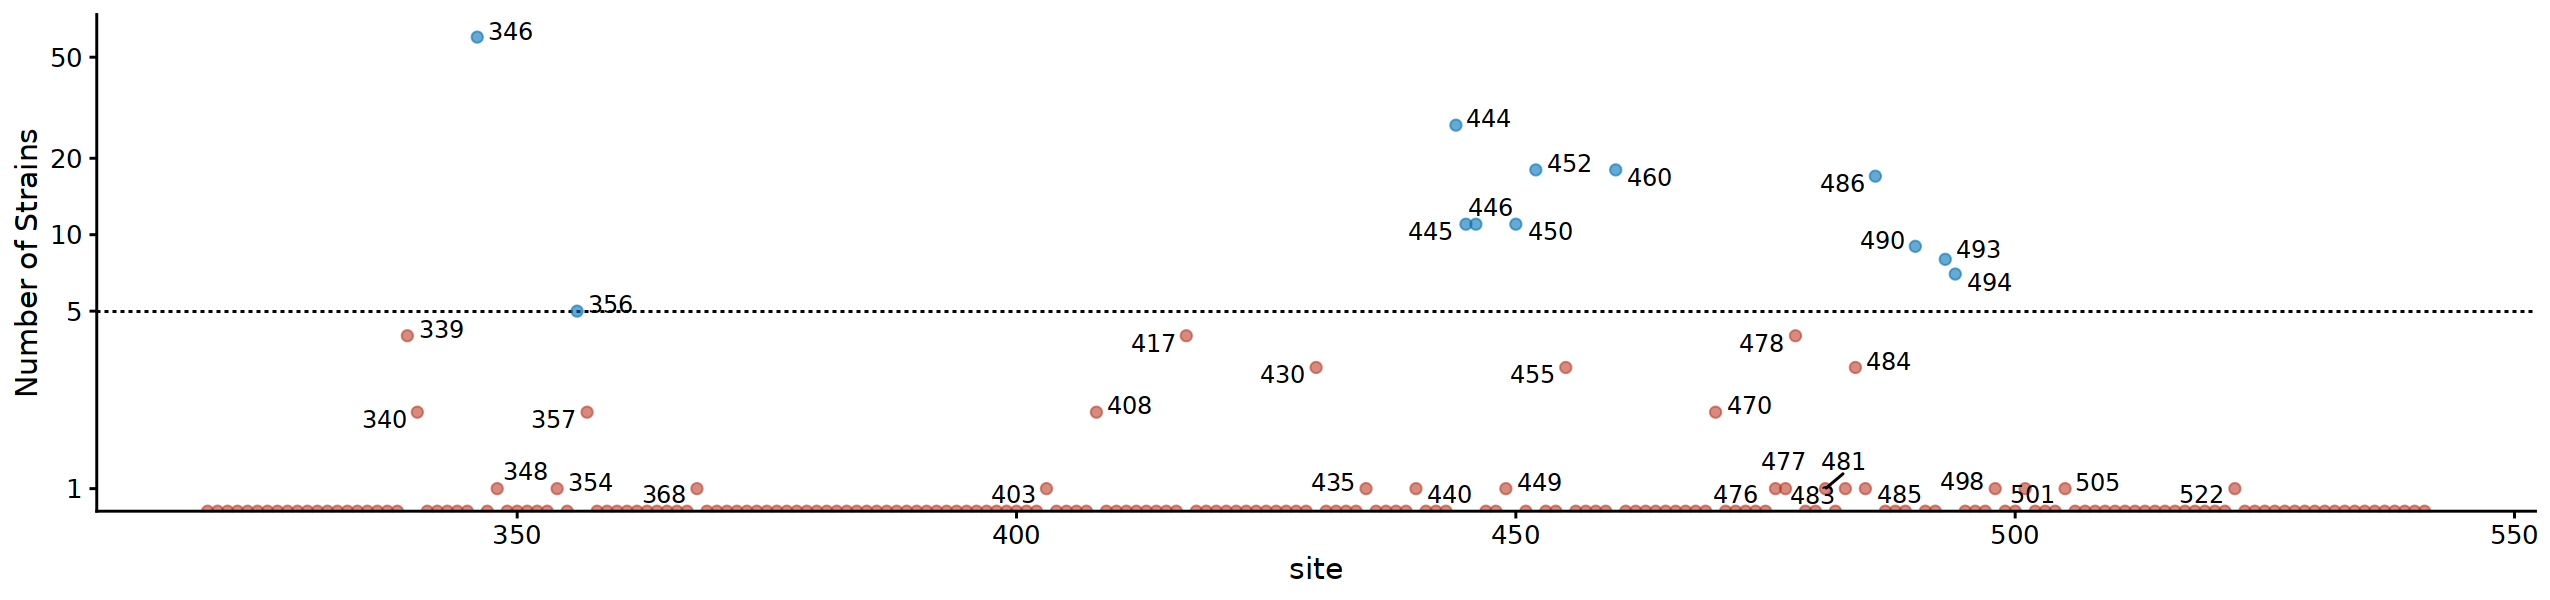

In [13]:
options(repr.plot.width=17, repr.plot.height=4, repr.plot.res=150)
# dash line
Nline <- TBmut_plot %>% filter(site == 356) %>% pull(n_strain)
# point plot
p <- TBmut_plot %>% ggplot(aes(x=site, y=n_strain)) + 
    geom_hline(yintercept=c(Nline), size=0.5, linetype='dashed') +
    geom_point(size=2, aes(color=n_strain > Nline - 0.00001), alpha=0.6) +
    geom_text_repel(aes(label=ifelse(site %in% Vmut_nozero, site, '')), max.overlaps=20) +
    scale_y_log10(breaks=c(1, 5, 10, 20, 50)) +
    labs(x='site', y='Number of Strains') +
    scale_color_nejm() +
    theme(legend.position='none')

p

In [14]:
ggsave('Adv_mut.pdf', p, width=17, height=4)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


In [15]:
########
## Table
########

In [16]:
get_all_strain <- function(df) {
    df %>% arrange(strain) %>% mutate(strain=str_c(strain, collapse=', ')) %>% slice(1)
}

In [17]:
TBsite_all_strain <- TBmut_temp %>% select(site, strain) %>% group_split(site) %>%
    map_dfr(get_all_strain)

In [18]:
TBsite_all_strain <- TBsite_all_strain %>% mutate(n_strain=str_count(strain, ', ') + 1, .after=site) %>%
    arrange(desc(n_strain))

In [19]:
wb <- createWorkbook(creator = 'william',title = '') 
addWorksheet(wb,sheetName = 'sheet1')
writeData(wb,sheet = 'sheet1', x=TBsite_all_strain)
saveWorkbook(wb, "site_all_strain.xlsx", overwrite = TRUE)